# Using `Stan` for inference

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../../')
import mwc.viz
import pandas as pd
import pystan as stan
mwc.viz.personal_style()
%matplotlib inline

In [7]:
# Load in the data using pandas. 
data = pd.read_csv('../../../mwc_induction/data/flow_master.csv')

In [60]:
# Define the model with Stan code. 
# First just fit Ka and Ki with O2 RBS1027.
model_code = """
data {
    int N;
    real y;
    real EpR; 
    real R;
    real EpAI;
    real c;
    int<lower=0> n;
    real<lower=0> Nns;
    }

parameters {
    real<lower=-7, upper=7> EpA;
    real<lower=-7, upper=7> EpI;
    real<lower=0> Sigma;
    real<lower=0, upper=1> mu[N];
    }
    
transformed parameters { 
    real<lower=0, upper=1> pact =  ((1 + c * exp(-EpA)) ^ n)  / ((1 + c * exp(-EpA)) ^ n + exp(-EpAI) * (1 + c * exp(-EpI))^n);
    mu[N] = (1 + pact * (R / Nns) * exp(-EpR)) ^ -1;
    }
model {
    EpA ~ uniform(-7, 7);
    EpI ~ uniform(-7, 7);
    Sigma ~ halfnormal(10);
    y ~ normal(mu, sigma)
}
"""

fit_strain = data[(data['rbs']=='RBS1027') & (data['operator']=='O2')]
data_dict = dict(N=len(fit_strain), R=2 * fit_strain['repressors'], y=fit_strain['fold_change_A'], EpR=fit_strain['binding_energy'].unique(),
                EpAI=4.5, c=fit_strain['IPTG_uM'], n=2, Nns=4.6E6)
model = stan.StanModel(model_code=model_code)

ValueError: Failed to parse Stan model 'anon_model_5f52a7ad34667cfec92d583353898b8a'. Error message:
SYNTAX ERROR, MESSAGE(S) FROM PARSER:

Cannot assign to variable outside of declaration block; left-hand-side variable origin=parameter
  error in 'unkown file name' at line 22, column 12
  -------------------------------------------------
    20: transformed parameters { 
    21:     real<lower=0, upper=1> pact =  ((1 + c * exp(-EpA)) ^ n)  / ((1 + c * exp(-EpA)) ^ n + exp(-EpAI) * (1 + c * exp(-EpI))^n);
    22:     mu[N] = (1 + pact * (R / Nns) * exp(-EpR)) ^ -1;
                   ^
    23:     }
  -------------------------------------------------

PARSER EXPECTED: <expression assignable to left-hand side>


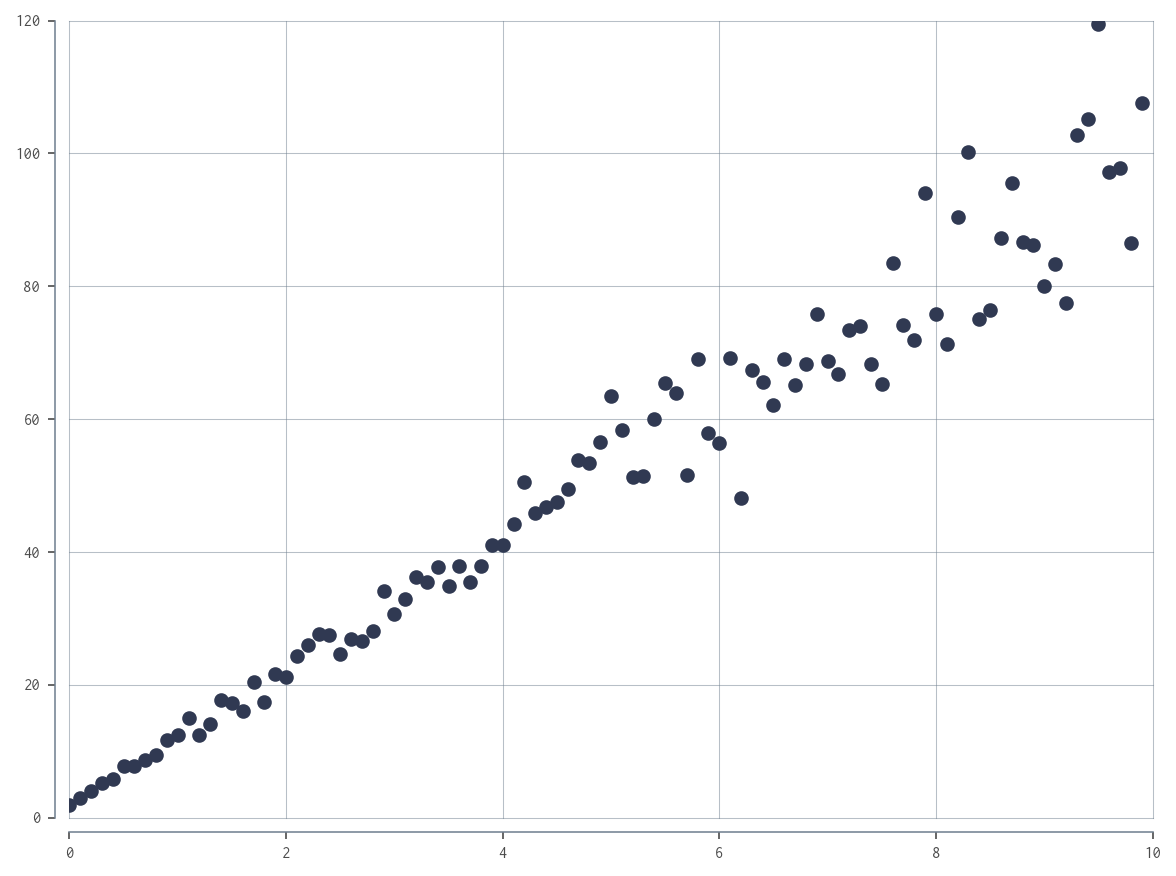

In [39]:
x = np.arange(0, 10, 0.1)
b = 2
y = np.random.normal(10, 1, size=len(x)) * x + b 
plt.plot(x, y, 'o')
plt.ylim([0, 120])
plt.xlim([0, 10])
mwc.viz.format_axes()

In [56]:
model_code = """
data {
    int N;
    real x[N];
    real y[N];
}

parameters {
    real a;
    real b;
    real<lower=0> sigma;
}

transformed parameters {
 real mu[N] = a * x + b;
}

model {
    a ~ uniform(0, 100);
    b ~ uniform(0, 10);
    sigma ~ normal(1, 0.1);
    y ~ normal(mu, sigma);
}
"""

model = stan.StanModel(model_code=model_code)

ValueError: Failed to parse Stan model 'anon_model_18b4ccd3d64b7f1dd04f13bc5ef1a0d8'. Error message:
SYNTAX ERROR, MESSAGE(S) FROM PARSER:

No matches for: 

  real * real[]

Available argument signatures for operator*:

  real * real
  vector * real
  row vector * real
  matrix * real
  row vector * vector
  vector * row vector
  matrix * vector
  row vector * matrix
  matrix * matrix
  real * vector
  real * row vector
  real * matrix

No matches for: 

  ill formed + real

Available argument signatures for operator+:

  int + int
  real + real
  vector + vector
  row vector + row vector
  matrix + matrix
  vector + real
  row vector + real
  matrix + real
  real + vector
  real + row vector
  real + matrix
  +int
  +real
  +vector
  +row vector
  +matrix

expression is ill formed
  error in 'unkown file name' at line 15, column 24
  -------------------------------------------------
    13: 
    14: transformed parameters {
    15:  real mu[N] = a * x + b;
                               ^
    16: }
  -------------------------------------------------



In [49]:
tracee = model.sampling(data=data_dict, iter=5000, chains=5)

RuntimeError: Exception: mismatch in number dimensions declared and found in context; processing stage=data initialization; variable name=x; dims declared=(); dims found=(100)  (in 'unkown file name' at line 3)


In [ ]:
trace.plot()
mwc.viz.format_axes()